In [6]:
import pandas
from pandas import DataFrame
import statsmodels
import matplotlib.pyplot as plt
import pylab as pl
import numpy
import imp

from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.grid_search import GridSearchCV

import xgboost as xgb

import multiprocessing
# N_JOBS = multiprocessing.cpu_count()
N_JOBS = 7

In [7]:
train = pandas.read_csv("train.csv")
test = pandas.read_csv("test.csv")

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


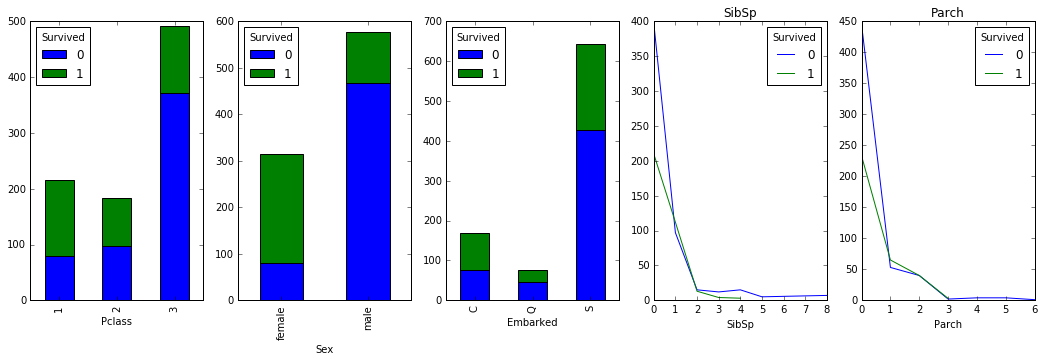

In [53]:
%matplotlib inline
fig, axes = plt.subplots(ncols = 5)
fig.set_size_inches(18, 5)
train.pivot_table('PassengerId', 'Pclass', 'Survived', 'count').plot(ax = axes[0], kind='bar', stacked=True)
train.pivot_table('PassengerId', 'Sex', 'Survived', 'count').plot(ax = axes[1], kind='bar', stacked=True)
train.pivot_table('PassengerId', 'Embarked', 'Survived', 'count').plot(ax = axes[2], kind='bar', stacked=True)
train.pivot_table('PassengerId', ['SibSp'], 'Survived', 'count').plot(ax=axes[3], title='SibSp')
train.pivot_table('PassengerId', ['Parch'], 'Survived', 'count').plot(ax=axes[4], title='Parch')

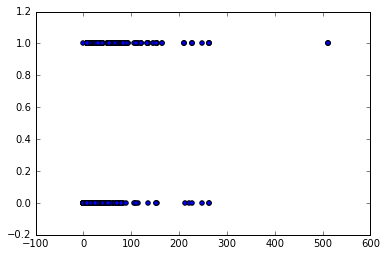

In [54]:
%matplotlib inline
plt.scatter(train['Fare'], train['Survived'])
plt.show()

In [8]:
#
# Preprocessing and scaling
#

import llama
llama = imp.reload(llama)


train = pandas.read_csv("train.csv")
test = pandas.read_csv("test.csv")
test_pid = test['PassengerId']

llama.replace_nan_fair(train)
llama.replace_nan_age(train)
llama.replace_nan_fair(test)
llama.replace_nan_age(test)

llama.set_family_size(train)
llama.set_family_size(test)

llama.set_title_column(train, test)
train = train.drop("Title", 1)
test = test.drop("Title", 1)

# columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch']
dummy_columns = ['Pclass', 'Sex', 'Embarked']
train = llama.make_dummies(llama.drop_columns(train, columns_to_drop), dummy_columns)
test = llama.make_dummies(llama.drop_columns(test, columns_to_drop), dummy_columns)

llama.normalise(train, test, ['Fare', 'Age'])

print(train.columns)
print(len(train.columns))
print(test.columns)
print(len(test.columns))
train.describe()
train.head()

Index(['Survived', 'Age', 'Fare', 'FamilySize', 'Title_1', 'Title_2',
       'Title_3', 'Title_4', 'Title_5', 'Title_6', 'Title_7', 'Title_8',
       'Title_9', 'Title_10', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')
22
Index(['Age', 'Fare', 'FamilySize', 'Title_1', 'Title_2', 'Title_3', 'Title_4',
       'Title_5', 'Title_6', 'Title_7', 'Title_8', 'Title_9', 'Title_10',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')
21


,Survived,Age,Fare,FamilySize,Title_1,Title_2,Title_3,Title_4,Title_5,Title_6,...,Title_9,Title_10,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,0.273456,0.014151,1,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
1,1,0.473882,0.139136,1,0,0,1,0,0,0,...,0,0,1,0,0,1,0,1,0,0
2,1,0.323563,0.015469,0,0,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,1
3,1,0.436302,0.103644,1,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1
4,0,0.436302,0.015713,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1


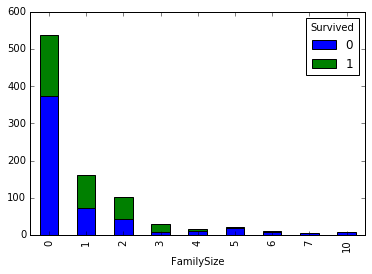

In [56]:
%matplotlib inline
train.insert(0, 'PassengerId', [x for x in range(len(train))])
train.pivot_table('PassengerId', 'FamilySize', 'Survived', 'count').plot(kind='bar', stacked=True)

In [9]:
#
# Shuffling for Cross Validation
#


if "PassengerId" in train.columns:
    train = train.drop("PassengerId", 1)
train_y = train['Survived']
train_X = train.drop('Survived', 1)

train_shuf = StratifiedShuffleSplit(train_y, n_iter = 5, test_size = .2, random_state = 123)

In [13]:
#
# Classifiers
#


def run_grid_search(train_X, train_y, clf, params, cv, n_jobs = N_JOBS):
    gs = GridSearchCV(clf, params, n_jobs = n_jobs, cv = cv, verbose=1)
    gs = gs.fit(train_X, train_y)
    print("Best estimator:\n", gs.best_estimator_)
    print("Grid search score:\t", gs.best_score_)
    clf = gs.best_estimator_
    cv_new = StratifiedShuffleSplit(train_y, n_iter = 10, test_size = .2, random_state = 345)
    score = cross_val_score(clf, train_X, train_y, cv=cv_new)
    print("CV score:\t", score, '\n=> ', score.mean(), ' (+-', score.std(),')\n', sep = '')
    return clf


gbm = xgb.XGBClassifier


# ENSEMBLES
clf_list = []
par_list = []

clf_list.append(gbm())
temp_par = {'max_depth': [2,3,4,5,6],
            'learning_rate': [.1, .05], 
            'n_estimators': [20, 50, 100, 200, 300]
            }
par_list.append(temp_par)

best_clf = run_grid_search(train_X, train_y, clf_list[0], par_list[0], train_shuf, 1)

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    4.3s


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best estimator:
 XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
Grid search score:	 0.841340782123
CV score:	[ 0.87709497  0.82122905  0.78212291  0.83798883  0.83240223  0.8603352
  0.84357542  0.83240223  0.78212291  0.79888268]
=> 0.826815642458 (+-0.0298765183399)



[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    5.8s finished


In [14]:
#
# Writing the output
#

clf = best_clf
postfix = ".gbm"
print(clf)
clf.fit(train_X, train_y)

result = DataFrame()
clf.predict(test)
result.insert(0, 'PassengerId', test_pid)
result.insert(1, "Survived", clf.predict(test))

result.to_csv("out" + postfix + ".csv", index = False)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
